In [7]:
!pip install catboost scikit-plot

In [9]:
import pandas as pd
import numpy as np

import re, math, os

from collections import Counter, defaultdict

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as ctb
#import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

As we did previously e.g. in Lab.I.80, let's collect individual training reviews into a list of chains: one chain per review.
We also collect review labels (positive/negative) for the labels list.

In [10]:
import os, sys, io
import numpy as np
from io import BytesIO, StringIO
from project_lib import Project

## Train DataFrame

In [11]:
import os, types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_a205bd0ef67d4e43a20f54571521aa41 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_a205bd0ef67d4e43a20f54571521aa41 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='3oTQ_GU9OAHXSgCgxR06S1CTzFOR44-4KvNuuoVgBqux',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_a205bd0ef67d4e43a20f54571521aa41)
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_4 = client_a205bd0ef67d4e43a20f54571521aa41.get_object(Bucket='2020l-donotdelete-pr-iya5gjhbhguf6w', Key='aclImdb.zip')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_4, "__iter__"): streaming_body_4.__iter__ = types.MethodType( __iter__, streaming_body_4 ) 
    
data = streaming_body_4._raw_stream 

with open("imdb.zip", "wb") as outfile:
    # Copy the BytesIO stream to the output file
    outfile.write(data.read())
    

import zipfile
with zipfile.ZipFile('imdb.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [12]:
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [13]:
# create and load df from lists 'labels' and 'texts'
df = pd.DataFrame(columns=['labels', 'texts'])
df['labels']=labels
df['texts']=texts

In [14]:
df

,labels,texts
0,0,"Thanks to a dull, dimensionless screenplay by ..."
1,0,"First of all, the big named actors must need t..."
2,0,"Yep, the topic is a straight quote from the mo..."
3,0,I've always been enthusiastic about period dra...
4,0,Seeing all of the negative reviews for this mo...
...,...,...
24995,1,This movie is great fun to watch if you love f...
24996,1,"Enchanted April is a tone poem, an impressioni..."
24997,1,I thoroughly enjoyed the first part of this tw...
24998,1,Presenting Lily Mars is a real pleasant little...


In [15]:
# mixing
df = df.sample(frac = 1.0, random_state=33)

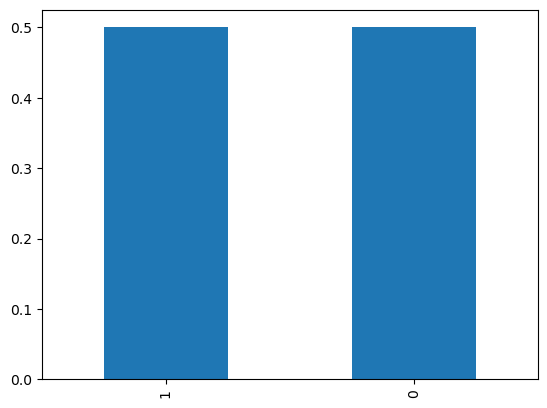

In [16]:
# distribution of labels in the training set
df['labels'].value_counts(normalize=True).plot(kind='bar');

## Test DataFrame

In [17]:
imdb_dir = './aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

labels_test = []
texts_test = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts_test.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

In [18]:
df_test = pd.DataFrame(columns=['labels', 'texts'])
df_test['labels']=labels_test
df_test['texts']=texts_test

In [19]:
df_test

,labels,texts
0,0,I rented this film for $5 and felt sorry I did...
1,0,It's boring.<br /><br />It's slow.<br /><br />...
2,0,"I have to admit, I'm not a big fan of Satanic ..."
3,0,"Hmmm! is it worst film ever? well sort of, for..."
4,0,This is a terrible film. Angie Dickenson is a ...
...,...,...
24995,1,this movie may not have seemed like much to so...
24996,1,Jean Renoir's homage to the Paris of the late ...
24997,1,"If there is such a thing as beautiful horror, ..."
24998,1,This was a really interesting Halloween film. ...


### Embedding reviews with gensim's word2vec

In [20]:
!pip install gensim nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.1/774.1 kB 35.1 MB/s eta 0:00:00


In [23]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string

# Function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing
    tokens = [word.lower() for word in tokens]
    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing to each review
df['processed_text'] = df['texts'].apply(preprocess_text)

# Train Word2Vec model
model = Word2Vec(sentences=df['processed_text'], vector_size=100, window=5, min_count=1, workers=4)

# Function to get vector representation of a review
def review_to_vec(review):
    vec = np.zeros(model.vector_size)
    count = 0
    for word in review:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

# Transform reviews to vectors
vectors = np.array([review_to_vec(review) for review in df['processed_text']])

print(vectors)


[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[[-0.49444049  0.65185212 -0.20262805 ... -0.29978586  0.1130101
  -0.06768045]
 [-0.70744927  0.24700383  0.00751413 ... -0.24356746  0.08839179
  -0.21531266]
 [-0.11401234  0.38412384  0.02248525 ... -0.06024845 -0.19606876
  -0.15946892]
 ...
 [-0.33544414  0.78503942 -0.11779283 ... -0.18386177 -0.09160256
  -0.4021806 ]
 [-0.54796047  0.5345536  -0.15771393 ... -0.23536184 -0.01190805
  -0.0207341 ]
 [-0.29860489  0.4610348  -0.08098738 ... -0.17980758  0.0598852
  -0.11437131]]


In [24]:
X_train_emb = vectors

df_test['processed_text'] = df_test['texts'].apply(preprocess_text)
X_test_emb = np.array([review_to_vec(review) for review in df_test['processed_text']])
print(X_test_emb.shape)

(25000, 100)


model=dummy, accuracy=0.50228
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.772 total time=   1.2s
[CV 2/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.760 total time=   1.0s
[CV 3/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.762 total time=   1.0s
[CV 1/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=5, n_estimators=150;, score=0.787 total time=   1.7s
[CV 2/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=5, n_estimators=150;, score=0.780 total time=   1.8s
[CV 3/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=5, n_estimators=150;, score=0.784 total time=   1.7s
[CV 1/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.786 total time=   4.4s
[CV 2/3] END l2_leaf_reg=1, learning_rate=0.01, max_depth=10, n_estimators=50;, score=0.780 total time=   4.3s
[CV 3/3] END l2_leaf_reg

/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

[CV 1/3] END .................C=1.0, penalty=l2;, score=0.843 total time=   0.2s
[CV 2/3] END .................C=1.0, penalty=l2;, score=0.841 total time=   0.2s


/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

[CV 3/3] END .................C=1.0, penalty=l2;, score=0.835 total time=   0.2s
[CV 1/3] END ................C=10.0, penalty=l2;, score=0.843 total time=   0.2s


/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

[CV 2/3] END ................C=10.0, penalty=l2;, score=0.841 total time=   0.2s
[CV 3/3] END ................C=10.0, penalty=l2;, score=0.839 total time=   0.2s


/opt/conda/envs/Python-RT23.1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model=LogisticRegression, accuracy=0.84448


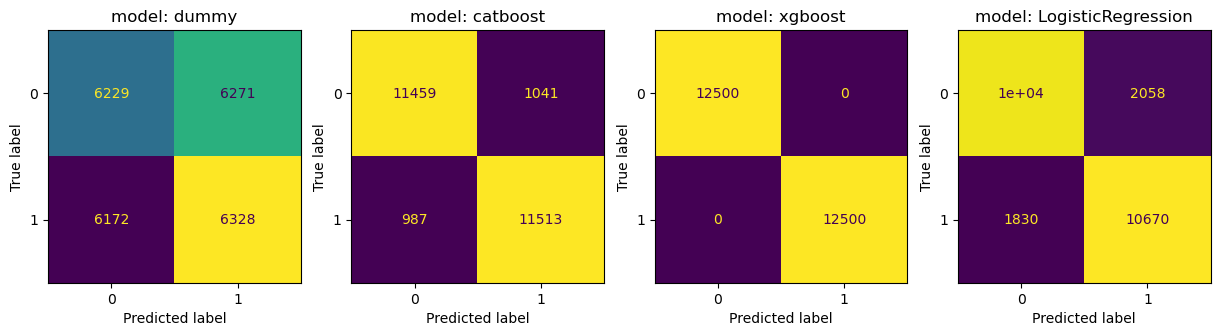

In [26]:
def get_models2(use_dummy):
    
    models = [('dummy', DummyClassifier(strategy='stratified'))] if use_dummy else []
    
    models += [
        ('catboost', ctb.CatBoostClassifier(random_state=0, verbose=0)),
        ('xgboost', xgb.XGBClassifier(random_state=0)),
        ('LogisticRegression', LogisticRegression(random_state=0))
    ] 

    parameters = {
        'LogisticRegression': {
            'C': [0.001, 0.01, 0.1, 1.0, 10.0],
            'penalty': ['l2'],
        },
        'catboost': {
            'n_estimators': [50, 150],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.5],
            'l2_leaf_reg': [1, 5],
        },
        'xgboost': {
            'n_estimators': [50, 150],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.5],
            'gamma': [0, 0.1, 0.2],
        }
        
    }

    models_with_grid_search = []
    for name, model in models:
        if name in parameters:
            grid_search = GridSearchCV(model, parameters[name], scoring='accuracy', n_jobs=1, verbose=5, cv=3)
            models_with_grid_search.append((name, grid_search))
        else:
            models_with_grid_search.append((name, model))

    return models_with_grid_search

def run_models2(X, y, use_dummy=True, scoring='accuracy', plot_result=False, show_confusion_matrix=True):
    result = []
    #cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    num_cols = 4
    if show_confusion_matrix:
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15,10))
    models=get_models2(use_dummy)

    for it, (model_name, model) in enumerate(models):
        clf = model
        clf.fit(X,y)
        y_pred = clf.predict(X)
        score = accuracy_score(y, y_pred)
        print("model={}, accuracy={}".format(model_name, score))

        if show_confusion_matrix:
            ax = axes[it]
            disp = ConfusionMatrixDisplay.from_predictions(y,y_pred,ax=ax,colorbar=None)
            disp.ax_.set_title('model: {}'.format(model_name))
    return models

models = run_models2(X_train_emb ,y_train)

Model: dummy, Accuracy: 0.5006, ROC AUC: 0.5006
Model: catboost, Accuracy: 0.8194, ROC AUC: 0.8194
Model: xgboost, Accuracy: 0.8231, ROC AUC: 0.8231
Model: logistic regression, Accuracy: 0.8417, ROC AUC: 0.8417


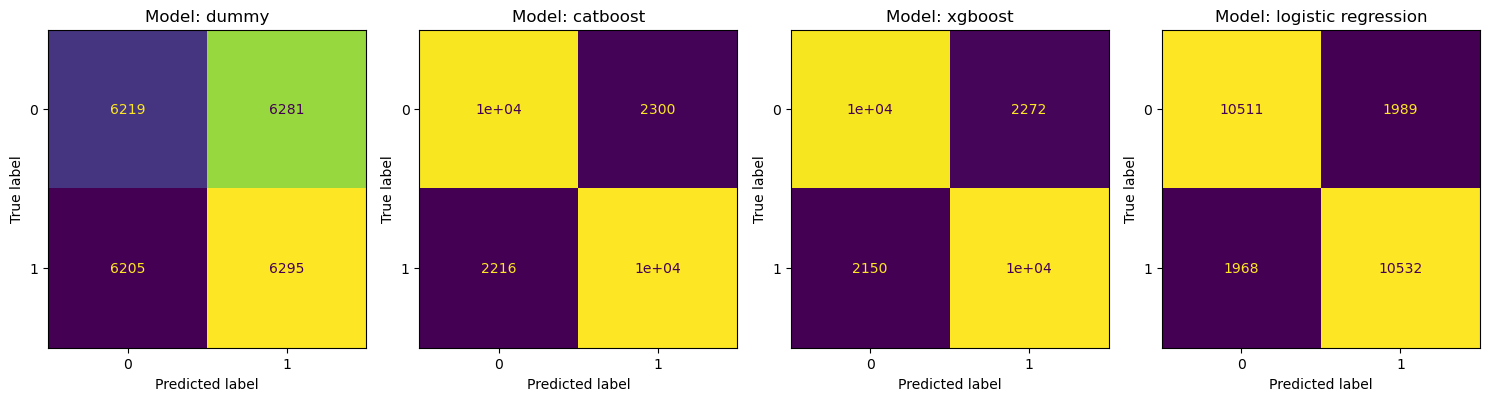

In [37]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

y_test = df_test['labels']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,10))
for i, (model_name, model) in enumerate(models):
    ax = axes[i]
    y_pred = model.predict(X_test_emb)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate ROC AUC
    if len(np.unique(y_pred)) > 1:  # Ensure at least two classes are present
        roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        
    if 'Logistic' in model_name:
        model_name = 'logistic regression'
        
    print("Model: {}, Accuracy: {:.4f}, ROC AUC: {:.4f}".format(model_name, accuracy, roc_auc))
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=None)
    disp.ax_.set_title('Model: {}'.format(model_name))
    
plt.tight_layout()
plt.show()


In [87]:
for m in models:
    print(m[0])
    print(m[1].get_params())
    

dummy
{'constant': None, 'random_state': None, 'strategy': 'stratified'}
catboost
{'cv': 3, 'error_score': nan, 'estimator__verbose': 0, 'estimator__random_state': 0, 'estimator': <catboost.core.CatBoostClassifier object at 0x7fbeb9195ab0>, 'n_jobs': 1, 'param_grid': {'n_estimators': [50, 150], 'max_depth': [5, 10], 'learning_rate': [0.01, 0.5], 'l2_leaf_reg': [1, 5]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 5}
xgboost
{'cv': 3, 'error_score': nan, 'estimator__objective': 'binary:logistic', 'estimator__use_label_encoder': False, 'estimator__base_score': None, 'estimator__booster': None, 'estimator__callbacks': None, 'estimator__colsample_bylevel': None, 'estimator__colsample_bynode': None, 'estimator__colsample_bytree': None, 'estimator__early_stopping_rounds': None, 'estimator__enable_categorical': False, 'estimator__eval_metric': None, 'estimator__gamma': None, 'estimator__gpu_id': None, 'estimator__grow_policy': None,